In [55]:
#подключаем библиотеки
import pandas as pd
import pandahouse as ph
import numpy as np
from scipy import stats
import seaborn as sns
%matplotlib inline

In [56]:
#настройки графиков
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(15,6)}
        )

In [57]:
#подключаемся к кликхаусу
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240720'
}

q = """
SELECT user_id, exp_group, countIf(user_id, action = 'like') as likes, countIf(user_id, action = 'view') as views
FROM simulator_20240720.feed_actions 
WHERE toDate(time) >= toDate('2024-06-21') and toDate(time) <= toDate('2024-06-27') and exp_group in (2,3)
group by user_id, exp_group
"""

# Вытащили пользователей
users_df = ph.read_clickhouse(q, connection=connection)

In [58]:
#считаем CTR
users_df['ctr'] = users_df.likes / users_df.views

In [59]:
users_df.head()

,user_id,exp_group,likes,views,ctr
0,115383,3,38,248,0.153226
1,10326,3,24,132,0.181818
2,123580,3,25,122,0.204918
3,131473,2,19,98,0.193878
4,23985,2,12,44,0.272727


In [66]:
#10000 раз из каждоуй группы формируем подвыборки по 500 юзеров и прогоняем по ним t-тест

steps = 10000
sample_size = 500
p_values = []
threshold = 0

for _ in range(steps):
    group_2 = users_df[users_df.exp_group == 2].sample(sample_size)
    group_3 = users_df[users_df.exp_group == 3].sample(sample_size)
    t_result = stats.ttest_ind(group_2.ctr, group_3.ctr, equal_var=False)
    p_values.append(t_result[1])
    if t_result[1] <= 0.05:
        threshold += 1

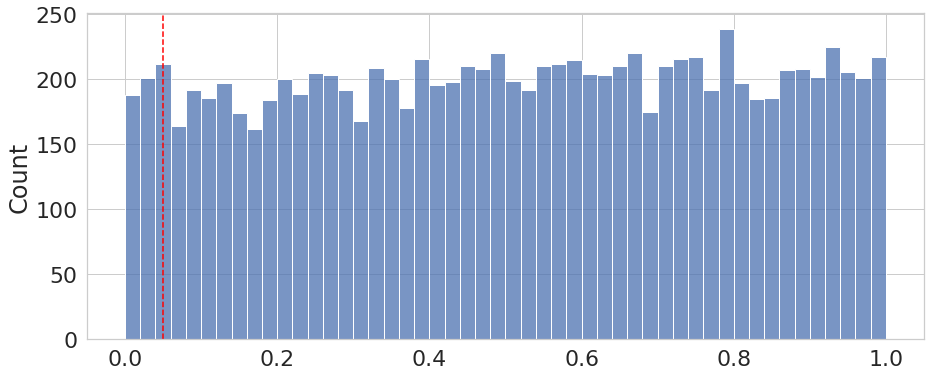

In [67]:
#строим гистограмму получученных p values
ax = sns.histplot(p_values, bins = 50)
ax.axvline(0.05, ls='--', color='red')

In [68]:
print('Доля p values <= 0.05: ' + f"{threshold/steps:.1%}")

Доля p values <= 0.05: 5.0%


<Axes: xlabel='ctr', ylabel='Count'>

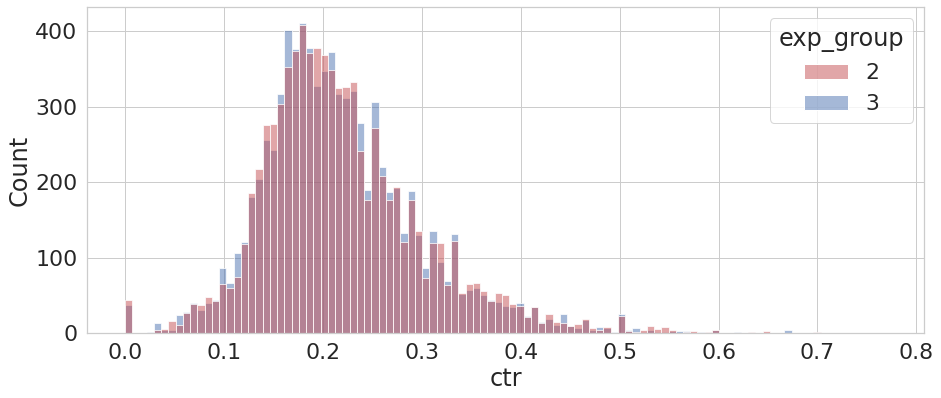

In [71]:
#посмотрим еще визуально распределение CTR в 2 и 3 группах
sns.histplot(data = users_df, x = 'ctr', hue = 'exp_group', palette = ['r', 'b'])

In [69]:
#и на всякий случай прогоним по исходным группам t-тест
stats.ttest_ind(users_df[users_df.exp_group == 2].ctr, users_df[users_df.exp_group == 3].ctr, equal_var=False)

Ttest_indResult(statistic=0.6617303509169987, pvalue=0.508153138292614)

p-value получилось 50%, что не позволяет нам отвергнуть нулевую гипотекзу о равенстве средних CTR

Исходя из полученных результатов, а именно:
1. Гистотрамму распределений CTR в наших 2х группах. Визуально наши группы "одинаковы".
2. При прогоне 1000 t-тестов по подвыборкам прокрасились лишь около 5% тестов. При этом если увеличить объемы подвыборок, то доля еще снизится.
3. Проведенный t-тест на исходных группах 2 и 3 показал p value на уровне 50%.

можно утверждать что наша система сплитования работает корректно.